In [1]:
%pylab inline 
import numpy as np
import pandas as pd
import os, sys
import random
import networkx as nx
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [29]:
class simplex_vertex:
    '''
    Vertex class for simplicial activity driven model
    '''
    import random
    def __init__(self,vertex_id,activity):
        self.act = activity;
        self.name = vertex_id;
        self.memory = [];
    
    def update_history(self,newcollab):
        self.memory.append(newcollab);
                
    def repeat_collaboration(self):
        s = random.choice(self.memory);
        self.memory.append(s)
        return s;

    def new_collab(self,nodes,size):
        el = random.sample(nodes,size);
        el.append(self.name);
        self.memory.append(el);
        return el;

def add_clique(e,tgraph):
    g = nx.complete_graph(len(e));
    rl = dict(zip(range(len(e)), e));
    g = nx.relabel_nodes(g,rl)
    tgraph.add_edges_from(g.edges());
    return tgraph;
        
def memory_instant_graph(vertex_dict):
    tgraph = nx.Graph()
    tgraph.add_nodes_from(vertex_dict.keys());
    new_history = []
    for n in vertex_dict:
        if np.random.rand()<=vertex_dict[n].act:
            if np.random.rand() <= (len(vertex_dict[n].memory) / float(1+len(vertex_dict[n].memory))):
                e = vertex_dict[n].repeat_collaboration();
                tgraph = add_clique(e,tgraph);                
            else:
                nodes = vertex_dict.keys();
                nodes.remove(n)
                e = vertex_dict[n].new_collab(nodes,np.random.randint(10));
            new_history.append(e);
            tgraph = add_clique(e,tgraph);
    return tgraph, new_history;

def memoryless_instant_graph(vertex_dict,k):
    tgraph = nx.Graph()
    tgraph.add_nodes_from(vertex_dict.keys());
    new_history = []
    for n in vertex_dict:
        if np.random.rand()<=vertex_dict[n].act:
            nodes = vertex_dict.keys();
            nodes.remove(n)
            e = vertex_dict[n].new_collab(nodes,k);
            new_history.append(e);
            tgraph = add_clique(e,tgraph);
    return tgraph, new_history;

def epidemic_step(tgraph,vertex_state,llambda, mmu):
    new_vertex_state = {}
    for n in vertex_state:
        
        ## recovery of infected nodes
        if vertex_state[n]=='i' and  np.random.rand()<mmu:
            new_vertex_state[n] = 's';
        else:
            new_vertex_state[n] = 'i';

        #infection of susceptible nodes 
        if vertex_state[n]=='s':
            new_vertex_state[n] = 's';
            for nn in tgraph.neighbors(n):
                if vertex_state[nn]=='i' and np.random.rand()<llambda:
                    new_vertex_state[n] = 'i';
                    break;
    return new_vertex_state;

def full_epidemic_sim(N,T,llambda,mmu,k,act,seed=1,verbose=False):
    vertex_dict = {}
    vertex_state = {}
    full_history = {}
    infection_history = {}
    for n in range(N):
        vertex_dict[n] = simplex_vertex(n,act[n])
        if n < seed:
            vertex_state[n] = 'i';
        else:
            vertex_state[n] = 's';
    
    for t in range(T):
        if verbose == True and T%100==0:
            print T;
        tg, fh = memoryless_instant_graph(vertex_dict,k);
        full_history[t] = fh;
        vertex_state = epidemic_step(tg, vertex_state,llambda,mmu);
        infection_history[t] = vertex_state;
    return infection_history, full_history;

def threshold_ratio(k, a1,a2):
    return 2.0 / (k*(k-1) * a1 + (k-1)*np.sqrt(k*k*a1*a1 + 4*(a2-a1*a1)));



def temporal_graph_creation(N,T,k,act,seed=1,verbose=False):
    tgraph = {}
    vertex_dict = {}
    full_history = {}
    for n in range(N):
        vertex_dict[n] = simplex_vertex(n,act[n])
        if n < seed:
            vertex_state[n] = 'i';
        else:
            vertex_state[n] = 's';
    for t in range(T):
        if verbose == True and T%100==0:
            print T;
        tg, fh = memoryless_instant_graph(vertex_dict,k);
        tgraph[t] = tg
    return tgraph;


In [10]:
## test

0.109571491993 0.0150211137325


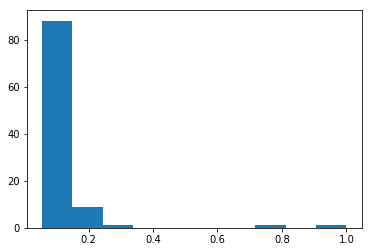

In [11]:
# produce activities 
from scipy.stats import norm,pareto
b = 2.1
dist = pareto(b).rvs(100000)
dist = np.random.choice(dist,100)
act = dict(zip(range(100),dist/np.max(dist)))
plt.hist(act.values())
mu, v  = np.mean(act.values()), np.var(act.values())
print mu, v

In [12]:
# predict thresholds
ks = range(2,6)
thrs = {}
for k in ks:
    thrs[k] = threshold_ratio(k,mu,v)
    print k, thrs[k]

max_lambda = 0.1;
[max_lambda / thrs[k] for k in thrs]

2 4.30789108859
3 1.48084710025
4 0.748961378726
5 0.451828829193


[0.023213214527368152,
 0.067528916377220513,
 0.13351823317000466,
 0.22132275219931713]

In [26]:
import time
epi  = {}
T  = 3000;
N = 100;
recovery_factor = 1.02
for k in ks:
    now = time.time()
    print 'lambda, mu', max_lambda,max_lambda/thrs[k]
    epi[k] = full_epidemic_sim(N,T,max_lambda,recovery_factor*max_lambda/thrs[k],k,act,seed=10)
    print 'Completed', k, time.time() - now

lambda, mu 0.1 0.0232132145274
Completed 2 3.97975802422
lambda, mu 0.1 0.0675289163772
Completed 3 5.80189108849
lambda, mu 0.1 0.13351823317
Completed 4 10.4714400768
lambda, mu 0.1 0.221322752199
Completed 5 12.5929570198


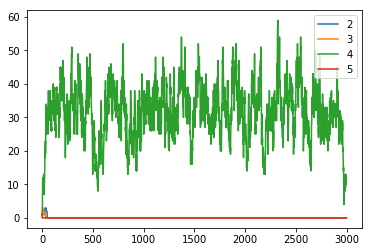

In [27]:
for k in epi:
    t = pd.DataFrame(epi[k][0]).replace(['s','i'],[0,1]);
    t.sum().plot(label=k)
plt.legend()

In [7]:
N = 100;
vertex_dict = {}
vertex_state = {}
seed = 1;
for n in range(N):
    vertex_dict[n] = simplex_vertex(n,np.random.rand())
    if n < seed:
        vertex_state[n] = 'i';
    else:
        vertex_state[n] = 's';

In [8]:
full_history = {}
T = 100;
for t in range(T):
    full_history[t] = []
    for n in vertex_dict:
        if np.random.rand()<=vertex_dict[n].act:
            if np.random.rand() <= (len(vertex_dict[n].memory) / float(1+len(vertex_dict[n].memory))):
                e = vertex_dict[n].repeat_collaboration();
                full_history[t].append(e);
            else:
                nodes = vertex_dict.keys();
                nodes.remove(n)
                e = vertex_dict[n].new_collab(nodes,np.random.randint(10));
                

In [9]:
vertex_dict[1].memory

[[14, 39, 1],
 [14, 39, 1],
 [1],
 [1],
 [87, 56, 4, 74, 52, 58, 1],
 [14, 39, 1],
 [14, 39, 1],
 [1],
 [14, 39, 1],
 [1],
 [6, 1],
 [6, 1],
 [6, 1],
 [90, 10, 16, 7, 92, 40, 36, 67, 22, 1],
 [6, 1],
 [6, 1],
 [14, 39, 1],
 [6, 1],
 [1],
 [6, 1],
 [1],
 [6, 1],
 [1],
 [87, 56, 4, 74, 52, 58, 1],
 [6, 1],
 [14, 39, 1],
 [14, 39, 1],
 [6, 1],
 [6, 1],
 [87, 56, 4, 74, 52, 58, 1],
 [1],
 [1],
 [1],
 [6, 1],
 [1],
 [87, 56, 4, 74, 52, 58, 1],
 [1],
 [14, 39, 1],
 [1],
 [87, 56, 4, 74, 52, 58, 1],
 [87, 56, 4, 74, 52, 58, 1],
 [1],
 [6, 1],
 [27, 33, 92, 48, 1],
 [6, 1],
 [1],
 [14, 39, 1],
 [14, 39, 1],
 [87, 56, 4, 74, 52, 58, 1],
 [14, 39, 1],
 [6, 1],
 [6, 1],
 [6, 1],
 [14, 39, 1],
 [14, 39, 1],
 [1],
 [1],
 [87, 56, 4, 74, 52, 58, 1],
 [6, 1],
 [6, 1],
 [14, 39, 1],
 [1],
 [87, 56, 4, 74, 52, 58, 1],
 [6, 1],
 [14, 39, 1],
 [87, 56, 4, 74, 52, 58, 1],
 [6, 1],
 [90, 10, 16, 7, 92, 40, 36, 67, 22, 1],
 [6, 1],
 [14, 39, 1],
 [6, 1],
 [14, 39, 1],
 [1],
 [0, 40, 3, 16, 50, 76, 19, 53, 2